1 and 2 parameter bifurcation diagrams for vdp-thal

# Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp

import vdp_thal

import importlib
import lib

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps,get_initial_phase_diff_c,get_es_min,get_es_max)

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)

import lib.rhs

importlib.reload(sys.modules['lib.util'])
importlib.reload(sys.modules['lib.rhs'])
from lib.util import (get_phase, freq_est)
#from lib.rhs import (_redu)
from lib.rhs import _redu_c2, _full, _full_mono_rhs

_redu = _redu_c2

from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

from matplotlib.patches import Circle

from scipy.optimize import root,bisect
from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

# Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-100,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,'del':0,
           'ib':8.2,'om':1,'om_fix':1}

pd_vdp = {'mu':.04,'sigmat':0.1,'vt':1,
          'alpha':3,'beta':2,'esyn':-2,
          'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws_thal = {'var_names':['v','h','r','w'],
            'pardict':pd_thal,
            'rhs':vdp_thal.rhs_thal,
            'coupling':vdp_thal.coupling_thal,
            'init':np.array([-.64,0.71,0.25,0,6]),
            'TN':10000,
            'trunc_order':1,
            'z_forward':False,
            'i_forward':False,
            'i_bad_dx':[False,True,False,False,False,False],
            'max_iter':20,
            'rtol':1e-12,
            'atol':1e-12,
            'rel_tol':1e-9,
            'save_fig':True,
            'lc_prominence':.05}

kws_vdp = {'var_names':['v','h','w'],
               'pardict':pd_vdp,
               'rhs':vdp_thal.rhs_vdp,
               'coupling':vdp_thal.coupling_vdp,
               'init':np.array([.32,0.128,0.54,20]),
               'TN':10000,
               'trunc_order':1,
               'z_forward':False,
               'i_forward':False,
               'i_bad_dx':[False,True,False,False,False,False],
               'max_iter':20,
               'rtol':1e-10,
               'atol':1e-10,
               'rel_tol':1e-8,
               'save_fig':True,
               'lc_prominence':.05}

In [5]:
het_coeffs = [1,20]

# Defs

In [6]:
mname1 = 'vdp_thal21_b={}'
mname2 = 'vdp_thal21_b2={}'

mname_list = ['vdp_thal11_b'+str(i)+'={}' for i in range(5)]

In [7]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':10000,
                    'rtol_lc':1e-11,
                    'atol_lc':1e-11,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'method':"LSODA",
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [8]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.concatenate([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=False,
                 return_full=False,skipn=200,**kwargs):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = path_loc+'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = path_loc+'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=skipn,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=skipn,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]
        #dat2[:,3] = solr_o3.y[0]
        #dat2[:,4] = solr_o4.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

# Initialize

In [9]:
system1 = rsp(idx=0,model_name='vdp_thal0',**kws_thal)
system2 = rsp(idx=1,model_name='vdp_thal1',**kws_vdp)

mkdir ./data/vdp_thal0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0084015231173136
self.T 6.283185307179586
LC0 ini[-0.10425117  0.22993228  0.09898925  0.40570217]
LC0 fin[-0.10425117  0.22993228  0.09898925  0.40570217]
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024653498269982924
* Loading g symbolic...
* Computing g...
g0 ini[0. 0. 0. 0.]
g0 fin[0. 0. 0. 0.]
g1 ini[ 0.00253413 -0.64088722 -0.22868543  0.73277563]
g1 fin[ 0.00253409 -0.64088719 -0.22868543  0.73277558]
* Loading heterogeneous terms...
* Computing z...
z0 ini[-0.87597607 -1.17574397  3.28529655 -0.        ]
z0 fin[-0.87597607 -1.17574397  3.28529652 -0.        ]
z1 ini[-1.70646067 -0.61636896  0.14424813  0.        ]
z1 fin[-1.70646067 -0.61636896  0.14424813  0.        ]
* Computing i...
i0 ini[-0.23544813  0.01818327 -4.42638639  0.        ]
i0 fin[-0.23544811  0.01818329 -4.4263864   0.        ]
i1 ini[-9.66309554e-02  7.45216330e-01 -6.49855309e-02  8.64027668e-21]

# Initialize Coupling 2:1

In [10]:
# parameters to be fixed for 1 par diagrams
nm_tup = (2,1)

In [11]:
a21 = nm.nmCoupling(system1,system2,
                    #recompute_list=['k_gwt1','p_gwt1'],
                    #recompute_list=['p_data_gwt0','p_data_gwt1','h_data_gwt0','h_data_gwt1'],
                    #recompute_list=recompute_list,
                    _n=('om0',nm_tup[0]),_m=('om1',nm_tup[1]),
                    het_coeffs=het_coeffs,
                    NH=1024)

Initializing 21 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


In [12]:
# define aliases as a template
a = a21

nm_val = str(nm_tup[0])+str(nm_tup[1])

In [13]:
etup = (.001,.2,100)
dtup = (-.4,.2)

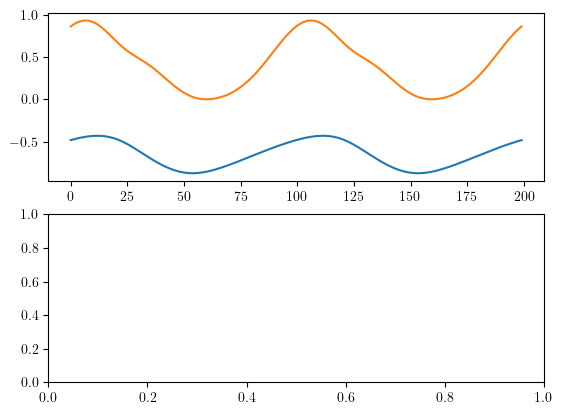

In [14]:
fig,axs = plt.subplots(2,1)
x_temp2 = np.linspace(0,2*np.pi,200)
rhs2 = a21.system1.h['lam_hom'][0](x_temp2)#_redu(0,x_temp2,a21,.1,-.0685)

rhs3 = a21.system1.h['lam_hom'][1](x_temp2)#_redu(0,x_temp2,a21,.1,-.0685)

axs[0].plot(rhs2)
axs[0].plot(rhs3)

## Phase line

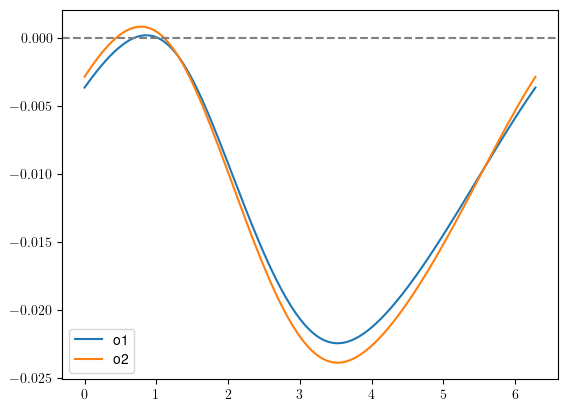

In [15]:
a = a21
e = .05
b = -.0685
x_temp2 = np.linspace(0,2*np.pi,200)

rhs1 = _redu(0,x_temp2,a,e,b,miter=1)
rhs2 = _redu(0,x_temp2,a,e,b)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs1,label='o1')
axs.plot(x_temp2,rhs2,label='o2')
axs.axhline(0,0,2*np.pi,ls='--',color='gray')
axs.legend()

## Plot 1par eps

<Axes: >

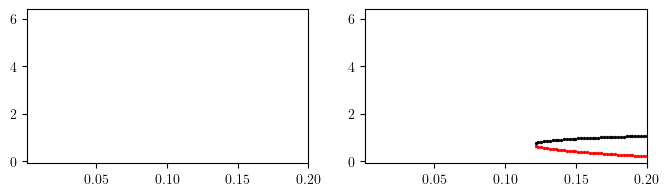

In [16]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.06,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

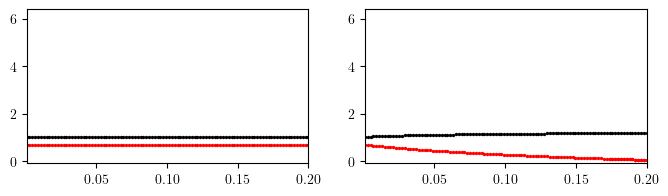

In [17]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.0685,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [18]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.069,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

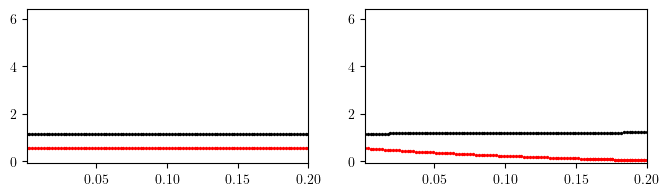

In [19]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.07,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [20]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.1,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

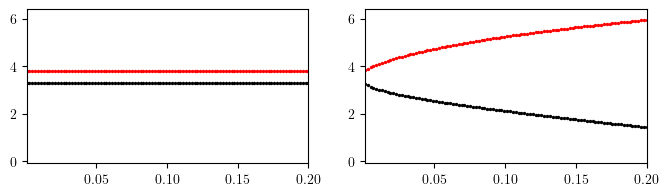

In [21]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.14,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [22]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.15,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

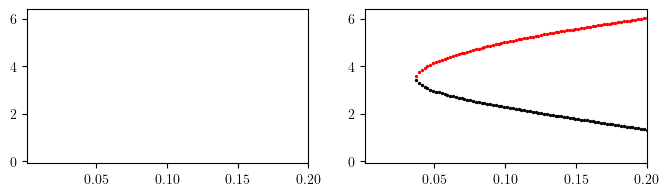

In [23]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.16,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

## Plot 1par del

In [24]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=e1,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)
# axs[0].set_xlabel('del'); axs[1].set_xlabel('del')

In [25]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=e2,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

## EPS VARY

In [26]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_u.txt'

In [27]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=-.06

#### Sim

In [28]:
# a=a21;T=2000;b=-.055;e=.03;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

#### Branches eps stable

In [29]:
# b=-.06
# kw_b['recompute'] = False
# kw_b['b'] = b

In [30]:
# # in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
# in_dicts = [
#     dict(phi0=2,eps_init=0.091,eps_final=0.001,deps=-.001),
#     # dict(phi0=2,eps_init=0.089,eps_final=0.13,deps=.001)
#            ]

In [31]:
# data_bs_list = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_b)
#     data_bs_list.append(dat)

In [32]:
# # save hyperparameters4
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [33]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [34]:
# # get an initial condition for an unstable branch
# phi_temp = np.mod(np.linspace(2*np.pi-.6,2*np.pi+.6,200),2*np.pi)
# for phi0 in phi_temp:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi0,eps_init=0.083,eps_final=0,deps=-1),return_point=True,**kw_b)

In [35]:
# #in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
# in_dicts = [
#     dict(phi0=5.5,eps_init=0.11,eps_final=0.001,deps=-.002),
#     dict(phi0=5.5,eps_init=0.109,eps_final=0.13,deps=.002)
# ]

In [36]:
# data_bu_list = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [37]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

In [38]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
# # add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# # add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_bs_list,a)
#     draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [39]:
# # just checking the period plot.
# fig,axs = plt.subplots(1,1,figsize=(8,2))
# axs.plot(data_bs_list[0][:,0],data_bs_list[0][:,1])

In [40]:
# b_vals_full.append(b)

# es = 0
# eu = get_smallest_eps(data_bu_list)

# e_vals_full.append(np.min([es,eu]))

# es = get_largest_eps(data_bs_list)
# eu = get_largest_eps(data_bu_list)

# e_hi_full.append(np.max([es,eu]))

### b=-.0685

#### Sim

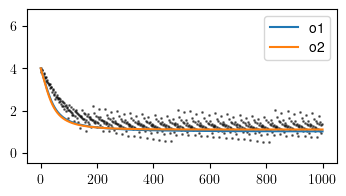

In [41]:
a=a21;T=1000;b=-0.0685;e=.05;phi0 = 4
dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)

solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)
ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

#### Branches eps stable

In [42]:
b=-.0685
kw_b['recompute'] = False
kw_b['b'] = b

In [43]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.05,eps_final=0.001,deps=-.001),
    dict(phi0=2,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=2,eps_init=0.1,eps_final=0.16,deps=.01)
]

In [44]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2
phi init 2


In [45]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [46]:
kw_b['recompute'] = False
kw_b['b'] = b

In [47]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=.0,eps_init=0.03,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 0.0
phase_diffs_u_init=0.0_nm=21_b=-0.0685_ei=0.03_ef=0_de=-1.txt
phase_diffs_u_pt_init=0.0_nm=21_b=-0.0685_ei=0.03_ef=0_de=-1.txt


In [48]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=.4,eps_init=0.03,eps_final=0,deps=-.001),
    dict(phi0=.4,eps_init=0.029,eps_final=0.102,deps=.002),
    dict(phi0=.4,eps_init=0.1,eps_final=0.16,deps=.01)
]

In [49]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.4
phase_diffs_u_init=0.4_nm=21_b=-0.0685_ei=0.03_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.4_nm=21_b=-0.0685_ei=0.03_ef=0_de=-0.001.txt
phi init 0.4
phase_diffs_u_init=0.4_nm=21_b=-0.0685_ei=0.029_ef=0.102_de=0.002.txt
phase_diffs_u_pt_init=0.4_nm=21_b=-0.0685_ei=0.029_ef=0.102_de=0.002.txt
phi init 0.4
phase_diffs_u_init=0.4_nm=21_b=-0.0685_ei=0.1_ef=0.16_de=0.01.txt
phase_diffs_u_pt_init=0.4_nm=21_b=-0.0685_ei=0.1_ef=0.16_de=0.01.txt


In [50]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

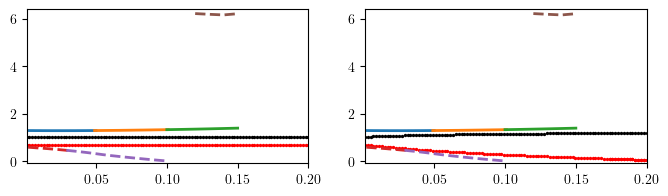

In [51]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [52]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.1

In [53]:
# # show original system
# a=a21;T=1000;b=-.14;e=.1;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(0,20)

#### Branches eps stable

In [54]:
b=-.1
kw_b['recompute'] = True
kw_b['b'] = b

In [55]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=2,eps_init=0.102,eps_final=0.15,deps=.01)
]

In [56]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
period_est 6.290062900629006 time_est 996.569965699657
iter, eps phase_diffs 0 0.05 [1.89873188]                               
iter, eps phase_diffs 1 0.049 [1.90671813]                              
iter, eps phase_diffs 2 0.048 [1.90532701]                              
iter, eps phase_diffs 3 0.047 [1.91470439]                              
iter, eps phase_diffs 4 0.046 [1.9173102]                               
iter, eps phase_diffs 5 0.045 [1.9213046]                               
iter, eps phase_diffs 6 0.044 [1.92929339]                              
iter, eps phase_diffs 7 0.043 [1.93328779]                              
iter, eps phase_diffs 8 0.041999999999999996 [1.93728218]                
iter, eps phase_diffs 9 0.040999999999999995 [1.94127658]                
iter, eps phase_diffs 10 0.039999999999999994 [1.94389167]                
iter, eps phase_diffs 11 0.03899999999999999 [1.951883]                 
iter, eps phase_diffs 12 0.03799999999999999 [1.957254

In [57]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [76]:
kw_b['recompute'] = False
kw_b['b'] = b

In [77]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5,eps_init=0.2,eps_final=0.19,deps=-1),return_point=True,**kw_b)

phi init 5
phase_diffs_u_init=5_nm=21_b=-0.1_ei=0.2_ef=0.19_de=-1.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.1_ei=0.2_ef=0.19_de=-1.txt
iter, eps phase_diffs 0 0.2 [6.06208794]                                

phase diff [[6.06208794]]


In [78]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=5,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=5,eps_init=0.1,eps_final=0.15,deps=.01)
           ]

In [79]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5
phase_diffs_u_init=5_nm=21_b=-0.1_ei=0.05_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.1_ei=0.05_ef=0_de=-0.001.txt
iter, eps phase_diffs 0 0.05 [5.90675483]                               
iter, eps phase_diffs 1 0.049 [5.90062605]                              
iter, eps phase_diffs 2 0.048 [5.89874567]                              
iter, eps phase_diffs 3 0.047 [5.89474109]                              
iter, eps phase_diffs 4 0.046 [5.89073651]                              
iter, eps phase_diffs 5 0.045 [5.89073651]                              
iter, eps phase_diffs 6 0.044 [5.88673193]                              
iter, eps phase_diffs 7 0.043 [5.88272735]                              
iter, eps phase_diffs 8 0.041999999999999996 [5.87872277]                
iter, eps phase_diffs 9 0.040999999999999995 [5.87471819]                
iter, eps phase_diffs 10 0.039999999999999994 [5.87471819]                
iter, eps phase_diffs 11 0.03899999999999999 [5.87071361]

In [81]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

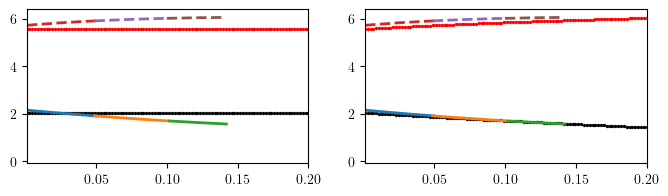

In [82]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [83]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.14

#### Branches eps stable

In [84]:
b=-.14
kw_b['recompute'] = False
kw_b['b'] = b

In [85]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=0,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=0,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=0,eps_init=0.1,eps_final=0.15,deps=.01)
]

In [86]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0
phi init 0


In [87]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [88]:
kw_b['recompute'] = False
kw_b['b'] = b

In [89]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=4.4,eps_init=0.2,eps_final=0.19,deps=-1),return_point=True,**kw_b)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.14_ei=0.2_ef=0.19_de=-1.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.14_ei=0.2_ef=0.19_de=-1.txt


In [90]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=4.4,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=5,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=5,eps_init=0.1,eps_final=0.15,deps=.01)
           ]

In [91]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.14_ei=0.05_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.14_ei=0.05_ef=0_de=-0.001.txt
phi init 5
phase_diffs_u_init=5_nm=21_b=-0.14_ei=0.049_ef=0.102_de=0.002.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.14_ei=0.049_ef=0.102_de=0.002.txt
phi init 5
phase_diffs_u_init=5_nm=21_b=-0.14_ei=0.1_ef=0.15_de=0.01.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.14_ei=0.1_ef=0.15_de=0.01.txt


In [92]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

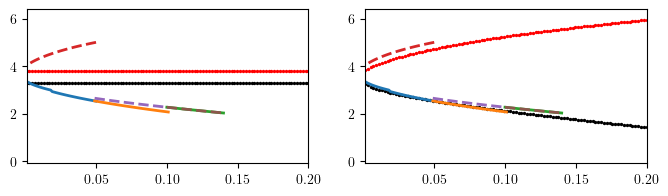

In [93]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [94]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

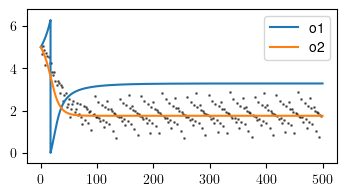

In [95]:
a=a21
T=500
b=-.14
e=.15
phi0 = 5
dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

### b=-.145

#### Branches eps stable

In [96]:
b=-.145
kw_b['recompute'] = False
kw_b['b'] = b

In [97]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.05,eps_final=0.001,deps=-.001),
    dict(phi0=4.4,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=4.4,eps_init=0.1,eps_final=0.15,deps=.01)
]

In [98]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 4.4
phi init 4.4


In [99]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [100]:
kw_b['recompute'] = False
kw_b['b'] = b

In [101]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5,eps_init=0.049,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5
phase_diffs_u_init=5_nm=21_b=-0.145_ei=0.049_ef=0_de=-1.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.145_ei=0.049_ef=0_de=-1.txt


In [102]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=4.8,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=4.8,eps_init=0.1,eps_final=0.15,deps=.01)
         ]

In [103]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5
phase_diffs_u_init=5_nm=21_b=-0.145_ei=0.05_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.145_ei=0.05_ef=0_de=-0.001.txt
phi init 4.8
phase_diffs_u_init=4.8_nm=21_b=-0.145_ei=0.049_ef=0.102_de=0.002.txt
phase_diffs_u_pt_init=4.8_nm=21_b=-0.145_ei=0.049_ef=0.102_de=0.002.txt
phi init 4.8
phase_diffs_u_init=4.8_nm=21_b=-0.145_ei=0.1_ef=0.15_de=0.01.txt
phase_diffs_u_pt_init=4.8_nm=21_b=-0.145_ei=0.1_ef=0.15_de=0.01.txt


In [104]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

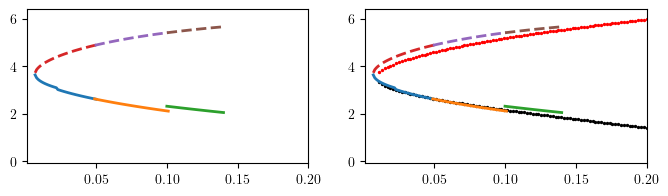

In [105]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [106]:
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
print(es_min,phi0)

0.006999999999999965 [0.007      3.14151265 3.62730698]


In [107]:
kw_b = {'a':a,'b':b,'recompute':True,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}

In [108]:
#0.03949999999999999 0.5339927959575679
dat = follow_phase_diffs(**dict(phi0=3.608949,eps_init=0.009499999999999965,eps_final=0,deps=-1,max_iter=50,max_time=10000,),**kw_b)

phi init 3.608949
period_est 6.280006280006281 time_est 9995.159995159996
iter, eps phase_diffs 0 0.009499999999999965 [3.39555972]                

data1 shape [[0.0095     3.14209267 3.39555972]]


In [109]:
# get_init_phase_diff_c 3.6089489989146175 <nmCoupling.nmCoupling object at 0x000001D7E2C371C0> 0.009499999999999965 -0.145 1000 <function _full at 0x000001D7E2C152D0> 0.05 {}
# period_est 6.2800628006280075 time_est 994.119941199412
# plfull phi0 3.6089489989146175 init [-0.10424773  0.22443272  0.09826049  0.41222445  0.41142074  1.95533595  0.32988058  6.2800628 ]
# eps 0.009499999999999965 coutner 0 b -0.145 dy [-1.52857460e-02 -6.15762412e+00 -1.00312452e-02  6.99262825e+00  1.04134669e+01 -2.35470989e+00  3.53681194e+00 -3.31762513e-02] Y [-0.10424773  0.22443272  0.09826049  0.41222445  0.41142074  1.95533595  0.32988058  6.2800628 ]

In [110]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.007099999999999965 3.6273069785455565
phi init 3.6273069785455565
Y [-1.04997403e-01  2.41041354e-01  9.84650457e-02  3.92295615e-01 -5.05593985e-01 -1.93360680e+00  6.81204349e-04  6.28311974e+00]
mkdir ./data/vdp_thal11_b0=-0.145/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999896375844936
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00012089023395895898
es_min,phi0 0.007599999999999964 3.6273069785455565
phi init 3.6273069785455565
Y [-1.04738645e-01  2.29428337e-01  9.84081003e-02  4.05633808e-01 -4.31289768e-01 -1.95166412e+00  6.30660285e-04  6.28321662e+00]
mkdir ./data/vdp_thal11_b1=-0.145/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000050147704207
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00024580071937959757
es_min,phi0 0.008099999999999965 3.6273069785455565
phi init 3.6273069785455565
Y [-1.04991828e-01  2.39568597e-

In [111]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.15

#### Branches eps stable

In [112]:
b=-.15
kw_b['recompute'] = False
kw_b['b'] = b

In [113]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2.6,eps_init=0.048,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.047,eps_final=0.102,deps=.002),
    dict(phi0=2,eps_init=0.1,eps_final=0.15,deps=.01)
]

In [114]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.6
phi init 2
phi init 2


In [115]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [116]:
kw_b['recompute'] = False
kw_b['b'] = b

In [117]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.1,eps_init=0.049,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.1
phase_diffs_u_init=5.1_nm=21_b=-0.15_ei=0.049_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.1_nm=21_b=-0.15_ei=0.049_ef=0_de=-1.txt


In [118]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5,eps_init=0.05,eps_final=0.001,deps=-.001),
    dict(phi0=5.1,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=5.1,eps_init=0.1,eps_final=0.15,deps=.01)
]

In [119]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5
phase_diffs_u_init=5_nm=21_b=-0.15_ei=0.05_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.15_ei=0.05_ef=0.001_de=-0.001.txt
phi init 5.1
phase_diffs_u_init=5.1_nm=21_b=-0.15_ei=0.049_ef=0.102_de=0.002.txt
phase_diffs_u_pt_init=5.1_nm=21_b=-0.15_ei=0.049_ef=0.102_de=0.002.txt
phi init 5.1
phase_diffs_u_init=5.1_nm=21_b=-0.15_ei=0.1_ef=0.15_de=0.01.txt
phase_diffs_u_pt_init=5.1_nm=21_b=-0.15_ei=0.1_ef=0.15_de=0.01.txt


In [120]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

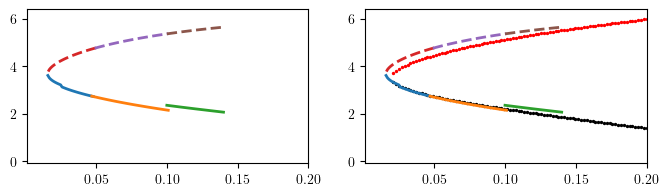

In [121]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [122]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.016099999999999972 3.6043915713646086
phi init 3.6043915713646086
Y [-1.05299020e-01  2.27400476e-01  9.77025202e-02  4.07227107e-01 -4.71763951e-01 -1.94100383e+00  6.59702931e-04  6.28313326e+00]
mkdir ./data/vdp_thal11_b0=-0.15/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999917550924367
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00039233030673942854
es_min,phi0 0.016599999999999972 3.6043915713646086
phi init 3.6043915713646086
Y [-1.05433739e-01  2.22524903e-01  9.76974337e-02  4.12746185e-01 -4.14538756e-01 -1.95414390e+00  6.21705531e-04  6.28331760e+00]
mkdir ./data/vdp_thal11_b1=-0.15/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000210803354992
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006256465740977235
es_min,phi0 0.017099999999999973 3.6043915713646086
phi init 3.6043915713646086
Y [-1.05521374e-01  2.38056628e-01 

In [123]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.155

#### Branches eps stable

In [124]:
b=-.155
kw_b['recompute'] = False
kw_b['b'] = b

In [125]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=2,eps_init=0.1,eps_final=0.15,deps=.01),
]

In [126]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2
phi init 2


In [127]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [128]:
kw_b['recompute'] = False
kw_b['b'] = b

In [129]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5,eps_init=0.2,eps_final=0.19,deps=-1),return_point=True,**kw_b)

phi init 5
phase_diffs_u_init=5_nm=21_b=-0.155_ei=0.2_ef=0.19_de=-1.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.155_ei=0.2_ef=0.19_de=-1.txt


In [130]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5.05,eps_init=0.05,eps_final=0,deps=-.002),
    dict(phi0=5.05,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=5.05,eps_init=0.1,eps_final=0.15,deps=.01),
]

In [131]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    print(dat)
    data_bu_list.append(dat)

phi init 5.05
phase_diffs_u_init=5.05_nm=21_b=-0.155_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.05_nm=21_b=-0.155_ei=0.05_ef=0_de=-0.002.txt
[[5.00000000e-02 3.13671263e+00 4.63982597e+00]
 [4.80000000e-02 3.13701264e+00 4.60032516e+00]
 [4.60000000e-02 3.13741264e+00 4.55928465e+00]
 [4.40000000e-02 3.13771264e+00 4.51539489e+00]
 [4.20000000e-02 3.13791264e+00 4.46985390e+00]
 [4.00000000e-02 3.13821264e+00 4.42117449e+00]
 [3.80000000e-02 3.13851264e+00 4.37010203e+00]
 [3.60000000e-02 3.13891264e+00 4.31509846e+00]
 [3.40000000e-02 3.13921264e+00 4.25604142e+00]
 [3.20000000e-02 3.13941264e+00 4.19052475e+00]
 [3.00000000e-02 3.13981265e+00 4.11794978e+00]
 [2.80000000e-02 3.14011265e+00 4.03331634e+00]
 [2.60000000e-02 3.14051265e+00 3.92836630e+00]
 [2.40000000e-02 3.14101265e+00 3.75830900e+00]
 [2.20000000e-02            nan            nan]
 [2.00000000e-02            nan            nan]
 [1.80000000e-02            nan            nan]
 [1.60000000e-02            nan    

In [132]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

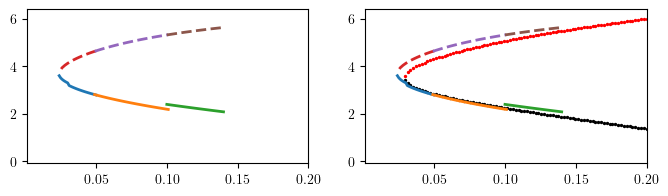

In [133]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [134]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.02409999999999998 3.595306034756005
phi init 3.595306034756005
Y [-1.05965192e-01  2.21179807e-01  9.70494205e-02  4.13655594e-01 -4.55371476e-01 -1.94420173e+00  6.50353380e-04  6.28319752e+00]
mkdir ./data/vdp_thal11_b0=-0.155/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000019866568461
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0007083104545091948
es_min,phi0 0.02459999999999998 3.595306034756005
phi init 3.595306034756005
Y [-1.05856446e-01  2.26516575e-01  9.71073003e-02  4.07517435e-01 -4.14097526e-01 -1.95348284e+00  6.23093025e-04  6.28345102e+00]
mkdir ./data/vdp_thal11_b1=-0.155/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000423100958642
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0010318297552541896
es_min,phi0 0.02509999999999998 3.595306034756005
phi init 3.595306034756005
Y [-1.05875077e-01  2.30764675e-01  9.71467

In [135]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.16

#### Branches eps stable

In [136]:
b=-.16
kw_b['recompute'] = False
kw_b['b'] = b

In [137]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=2,eps_init=0.1,eps_final=0.15,deps=.01),
]

In [138]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2
phi init 2


In [139]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [140]:
kw_b['recompute'] = False
kw_b['b'] = b

In [141]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=4.4,eps_init=0.05,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.16_ei=0.05_ef=0_de=-1.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.16_ei=0.05_ef=0_de=-1.txt


In [142]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=4.4,eps_init=0.05,eps_final=0,deps=-.001),
    dict(phi0=4.4,eps_init=0.049,eps_final=0.102,deps=.002),
    dict(phi0=4.5,eps_init=0.1,eps_final=0.15,deps=.01),
]

In [143]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.16_ei=0.05_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.16_ei=0.05_ef=0_de=-0.001.txt
phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.16_ei=0.049_ef=0.102_de=0.002.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.16_ei=0.049_ef=0.102_de=0.002.txt
phi init 4.5
phase_diffs_u_init=4.5_nm=21_b=-0.16_ei=0.1_ef=0.15_de=0.01.txt
phase_diffs_u_pt_init=4.5_nm=21_b=-0.16_ei=0.1_ef=0.15_de=0.01.txt


In [144]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

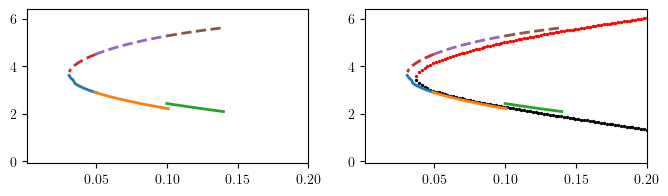

In [145]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [146]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.031099999999999985 3.607591563881625
phi init 3.607591563881625
Y [-1.06358496e-01  2.35089821e-01  9.65289423e-02  3.97009390e-01 -4.79217534e-01 -1.93791234e+00  6.68480944e-04  6.28319309e+00]
mkdir ./data/vdp_thal11_b0=-0.16/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000012692045668
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009229871915407438
es_min,phi0 0.03159999999999998 3.607591563881625
phi init 3.607591563881625
Y [-1.06376031e-01  2.34687181e-01  9.65874672e-02  3.97439351e-01 -4.29786217e-01 -1.94961336e+00  6.34865742e-04  6.28353094e+00]
mkdir ./data/vdp_thal11_b1=-0.16/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0004734932894597
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.003001851482767837
es_min,phi0 0.03209999999999998 3.607591563881625
phi init 3.607591563881625
Y [-1.06396217e-01  2.23543433e-01  9.6583395

In [147]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

In [148]:
data_bs_list

[array([[5.00000000e-02, 3.14461267e+00, 2.88323997e+00],
        [4.90000000e-02, 3.14441266e+00, 2.90260621e+00],
        [4.80000000e-02, 3.14431266e+00, 2.92248148e+00],
        [4.70000000e-02, 3.14421266e+00, 2.94315734e+00],
        [4.60000000e-02, 3.14411266e+00, 2.96383452e+00],
        [4.50000000e-02, 3.14391266e+00, 2.98560722e+00],
        [4.40000000e-02, 3.14381266e+00, 3.00828632e+00],
        [4.30000000e-02, 3.14361266e+00, 3.03126315e+00],
        [4.20000000e-02, 3.14351266e+00, 3.05554490e+00],
        [4.10000000e-02, 3.14331266e+00, 3.08092562e+00],
        [4.00000000e-02, 3.14311266e+00, 3.10750901e+00],
        [3.90000000e-02, 3.14301266e+00, 3.13579525e+00],
        [3.80000000e-02, 3.14291266e+00, 3.16568263e+00],
        [3.70000000e-02, 3.14281266e+00, 3.19797099e+00],
        [3.60000000e-02, 3.14261266e+00, 3.23256348e+00],
        [3.50000000e-02, 3.14241266e+00, 3.27115936e+00],
        [3.40000000e-02, 3.14231266e+00, 3.40403356e+00],
        [3.300

### b=-.2

#### Branches eps stable

In [149]:
b=-.2
kw_b['recompute'] = False
kw_b['b'] = b

In [150]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.099,eps_final=15,deps=.01),
]

In [151]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [152]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [153]:
kw_b['recompute'] = False
kw_b['b'] = b

In [154]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=4.4,eps_init=0.2,eps_final=0.19,deps=-1),return_point=True,**kw_b)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.2_ei=0.2_ef=0.19_de=-1.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.2_ei=0.2_ef=0.19_de=-1.txt


In [155]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=4.4,eps_init=0.1,eps_final=0,deps=-.001),
    dict(phi0=4.4,eps_init=0.099,eps_final=.15,deps=.01),
]

In [156]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.2_ei=0.1_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.2_ei=0.1_ef=0_de=-0.001.txt
phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.2_ei=0.099_ef=0.15_de=0.01.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.2_ei=0.099_ef=0.15_de=0.01.txt


In [157]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

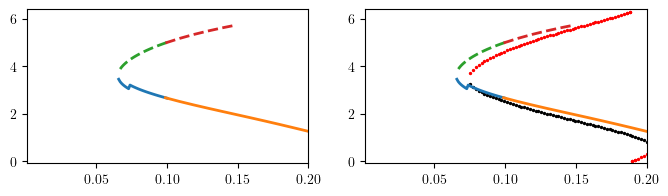

In [158]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [159]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06609999999999998 3.4469724983941368
phi init 3.4469724983941368
Y [-1.08616602e-01  2.29476631e-01  9.36501955e-02  4.00329188e-01 -4.73718219e-01 -1.94020166e+00  6.73043629e-04  6.28370995e+00]
mkdir ./data/vdp_thal11_b0=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006316211038786
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.01922136579755201+0j)
es_min,phi0 0.06659999999999998 3.4469724983941368
phi init 3.4469724983941368
Y [-0.10344564  0.23827593  0.0939777   0.39828876  0.27857789  1.97485825  0.28874964  6.28446669]
mkdir ./data/vdp_thal11_b1=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0008018498325497
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.02100051926631282+0j)
es_min,phi0 0.06709999999999998 3.4469724983941368
phi init 3.4469724983941368
Y [-0.10311596  0.23547667  0.09413618  0.40165901  0.23276848  1.9

In [160]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.3

#### Branches eps stable

In [161]:
b=-.3
kw_b['recompute'] = False
kw_b['b'] = b

In [162]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=3,eps_init=0.09,eps_final=0,deps=-.001),
    dict(phi0=3.01,eps_init=0.089,eps_final=0.152,deps=.002),
]

In [163]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3
phi init 3.01


In [164]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [165]:
kw_b['recompute'] = False
kw_b['b'] = b

In [166]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.4,eps_init=0.09,eps_final=0.19,deps=1),return_point=True,**kw_b)

phi init 5.4
phase_diffs_u_init=5.4_nm=21_b=-0.3_ei=0.09_ef=0.19_de=1.txt
phase_diffs_u_pt_init=5.4_nm=21_b=-0.3_ei=0.09_ef=0.19_de=1.txt
iter, eps phase_diffs 0 0.09 [4.63921213]                               

phase diff [[4.63921213]]


In [167]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=4.4,eps_init=0.09,eps_final=0,deps=-.001),
    dict(phi0=4.4,eps_init=0.089,eps_final=0.152,deps=.002),
]

In [168]:
data_bu_list = []

for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.3_ei=0.09_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.3_ei=0.09_ef=0_de=-0.001.txt
phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.3_ei=0.089_ef=0.152_de=0.002.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.3_ei=0.089_ef=0.152_de=0.002.txt
iter, eps phase_diffs 0 0.089 [4.563028]                                
iter, eps phase_diffs 1 0.091 [4.70486841]                              
iter, eps phase_diffs 2 0.093 [4.83321947]                              
iter, eps phase_diffs 3 0.095 [4.94309342]                              
iter, eps phase_diffs 4 0.097 [5.0450105]                               
iter, eps phase_diffs 5 0.099 [5.14133528]                              
iter, eps phase_diffs 6 0.101 [5.229633]                                
iter, eps phase_diffs 7 0.10300000000000001 [5.3116001]                 
iter, eps phase_diffs 8 0.10500000000000001 [5.3918964]                 
iter, eps phase_diffs 9 0.10700000000000001 [5.4681

In [169]:
# need to split because initial condition for unstable branch isn't working
in_dicts = [
    dict(phi0=5.4,eps_init=0.1,eps_final=0.2,deps=.002),
]

In [170]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.4
phase_diffs_u_init=5.4_nm=21_b=-0.3_ei=0.1_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=5.4_nm=21_b=-0.3_ei=0.1_ef=0.2_de=0.002.txt


In [171]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

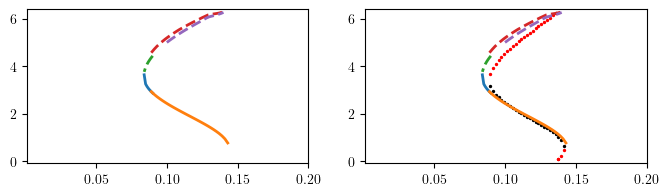

In [172]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [173]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0841 3.6332445545955956
phi init 3.6332445545955956
Y [-1.09842879e-01  2.25312454e-01  9.21716724e-02  4.03562154e-01 -4.66181153e-01 -1.94438396e+00  6.71916709e-04  6.28425272e+00]
mkdir ./data/vdp_thal11_b0=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991012371111494
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004763318711004449
es_min,phi0 0.0846 3.6332445545955956
phi init 3.6332445545955956
Y [-0.10278499  0.22458312  0.09277619  0.41442848  0.18292042  1.98625291  0.26253635  6.28583679]
mkdir ./data/vdp_thal11_b1=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9998501494715458
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.009967466967732047
es_min,phi0 0.0851 3.6332445545955956
phi init 3.6332445545955956
Y [-1.09973007e-01  2.35324855e-01  9.30098363e-02  3.91617212e-01 -3.26485618e-01 -1.97105138e+00  5.79558111e-04

#### Monodromys max

In [174]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.14390000000000006 0.1763490673327741
phi init 0.1763490673327741
Y [-0.11518055  0.23992317  0.10694618  0.38887797  1.38614219 -0.60378974  0.51695247  6.29415032]
mkdir ./data/vdp_thal11_b0=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991012371111494
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004763318711004449
es_min,phi0 0.14340000000000006 0.1763490673327741
phi init 0.1763490673327741
Y [-0.093976    0.23447301  0.10884994  0.41062437 -1.35676864  0.57588336  0.01410986  6.29579989]
mkdir ./data/vdp_thal11_b1=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9998501494715458
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.009967466967732047
es_min,phi0 0.14290000000000005 0.1763490673327741
phi init 0.1763490673327741
Y [-0.0937121   0.23369119  0.10899395  0.4117111  -1.35195067  0.60841649  0.01487545  6.29706827]
mkdir .

In [175]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.4

#### Branches eps stable

In [176]:
b=-.4
kw_b['recompute'] = False
kw_b['b'] = b

In [177]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.09,eps_final=0.001,deps=-.001),
    dict(phi0=2,eps_init=0.089,eps_final=0.15,deps=.001),
]

In [178]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [179]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [180]:
kw_b['recompute'] = False
kw_b['b'] = b

In [181]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=4.4,eps_init=0.09,eps_final=0.2,deps=1),return_point=True,**kw_b)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.4_ei=0.09_ef=0.2_de=1.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.4_ei=0.09_ef=0.2_de=1.txt


In [182]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=4.4,eps_init=0.09,eps_final=0.001,deps=-.001),
    dict(phi0=4.4,eps_init=0.089,eps_final=0.15,deps=.001),
]

In [183]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.4_ei=0.09_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.4_ei=0.09_ef=0.001_de=-0.001.txt
phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.4_ei=0.089_ef=0.15_de=0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.4_ei=0.089_ef=0.15_de=0.001.txt


In [184]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

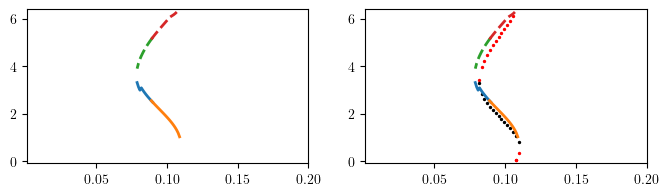

In [185]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [186]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07909999999999999 3.3059294972483726
phi init 3.3059294972483726
Y [-0.10261568  0.22823611  0.09339097  0.41033158  0.16838392  1.98638093  0.25841947  6.28608924]
mkdir ./data/vdp_thal11_b0=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0011764959365226
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0148062975515108
es_min,phi0 0.07959999999999999 3.3059294972483726
phi init 3.3059294972483726
Y [-1.09493237e-01  2.21291518e-01  9.37357802e-02  4.08878294e-01 -2.43903104e-01 -1.98083960e+00  5.30713262e-04  6.28775658e+00]
mkdir ./data/vdp_thal11_b1=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0013054138086612
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01751878408410053
es_min,phi0 0.08009999999999999 3.3059294972483726
phi init 3.3059294972483726
Y [-0.10138872  0.22812891  0.09449159  0.41132031 -0.01240857  1.98652317  0.

#### Monodromys max

In [187]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.10890000000000001 1.0231458395947364
phi init 1.0231458395947364
Y [-0.09546097  0.2309261   0.10612413  0.41303678 -1.43952637  0.76870052  0.0197359   6.29623778]
mkdir ./data/vdp_thal11_b0=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0011764959365226
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0148062975515108
es_min,phi0 0.10840000000000001 1.0231458395947364
phi init 1.0231458395947364
Y [-0.09527337  0.22804532  0.10614645  0.41634024 -1.42424506  0.81930389  0.02122786  6.2974728 ]
mkdir ./data/vdp_thal11_b1=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0013054138086612
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01751878408410053
es_min,phi0 0.10790000000000001 1.0231458395947364
phi init 1.0231458395947364
Y [-0.11209402  0.24084198  0.10491646  0.38877564  1.38784575 -0.95898601  0.4707053   6.29845725]
mkdir ./da

In [188]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.5

#### Branches eps stable

In [189]:
b=-.5
kw_b['recompute'] = False
kw_b['b'] = b

In [190]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.08,eps_final=0.001,deps=-.001),
    dict(phi0=2,eps_init=0.079,eps_final=0.13,deps=.001),
]

In [191]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [192]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [193]:
kw_b['recompute'] = False
kw_b['b'] = b

In [194]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=4.4,eps_init=0.08,eps_final=0.19,deps=1),return_point=True,**kw_b)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.5_ei=0.08_ef=0.19_de=1.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.5_ei=0.08_ef=0.19_de=1.txt


In [195]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=4.4,eps_init=0.08,eps_final=0.001,deps=-.001),
    dict(phi0=4.4,eps_init=0.079,eps_final=0.13,deps=.001),
]

In [196]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.5_ei=0.08_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.5_ei=0.08_ef=0.001_de=-0.001.txt
phi init 4.4
phase_diffs_u_init=4.4_nm=21_b=-0.5_ei=0.079_ef=0.13_de=0.001.txt
phase_diffs_u_pt_init=4.4_nm=21_b=-0.5_ei=0.079_ef=0.13_de=0.001.txt


In [197]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5,eps_init=0.074,eps_final=0.2,deps=.002)
]

In [198]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5
phase_diffs_u_init=5_nm=21_b=-0.5_ei=0.074_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.5_ei=0.074_ef=0.2_de=0.002.txt


In [199]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

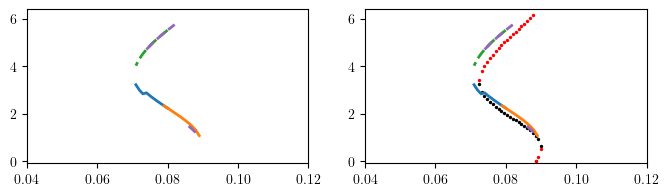

In [200]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(.04,.12,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [201]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0711 3.215749991153063
phi init 3.215749991153063
Y [-1.08903725e-01  2.33109948e-01  9.44086190e-02  3.95697950e-01 -2.45688848e-01 -1.97978315e+00  5.30447108e-04  6.28730239e+00]
mkdir ./data/vdp_thal11_b0=-0.5/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006552602059766
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008122963722159421
es_min,phi0 0.0716 3.215749991153063
phi init 3.215749991153063
Y [-0.10144865  0.23460957  0.09531692  0.40392572 -0.0361716   1.98441978  0.20907854  6.28902068]
mkdir ./data/vdp_thal11_b1=-0.5/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0009287336849757
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.010733386241972887
es_min,phi0 0.0721 3.215749991153063
phi init 3.215749991153063
Y [-1.08810567e-01  2.34276658e-01  9.55659323e-02  3.94476940e-01 -3.10313113e-02 -1.98651686e+00  4.27415468e-04  6.29

#### Monodromys max

In [202]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0889 1.0725198268300549
phi init 1.0725198268300549
Y [-0.11140086  0.24120521  0.10352858  0.3888162   1.46890184 -0.92925809  0.5045142   6.29458107]
mkdir ./data/vdp_thal11_b0=-0.5/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006552602059766
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008122963722159421
es_min,phi0 0.0884 1.0725198268300549
phi init 1.0725198268300549
Y [-0.09669469  0.23729377  0.10455296  0.40503501 -1.44431967  0.94088343  0.02530804  6.29603966]
mkdir ./data/vdp_thal11_b1=-0.5/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0009287336849757
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.010733386241972887
es_min,phi0 0.0879 1.0725198268300549
phi init 1.0725198268300549
Y [-0.09651062  0.23616446  0.10449492  0.40643067 -1.41406912  1.00728696  0.02776126  6.29708219]
mkdir ./data/vdp_thal11_b2=-0.5/
* Loading LC 

In [203]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.6

#### Branches eps stable

In [204]:
b=-.6
kw_b['recompute'] = False
kw_b['b'] = b

In [205]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.002) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.075,eps_final=0.001,deps=-.001),
    dict(phi0=2,eps_init=0.074,eps_final=0.13,deps=.001),
]

In [206]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [207]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [208]:
kw_b['recompute'] = False
kw_b['b'] = b

In [209]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.,eps_init=0.07,eps_final=0.19,deps=1),return_point=True,**kw_b)

phi init 5.0
phase_diffs_u_init=5.0_nm=21_b=-0.6_ei=0.07_ef=0.19_de=1.txt
phase_diffs_u_pt_init=5.0_nm=21_b=-0.6_ei=0.07_ef=0.19_de=1.txt


In [210]:
# # get an initial condition for an unstable branch
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=6.2,eps_init=0.073,eps_final=0.19,deps=1),return_point=True,**kw_b)

In [211]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.002) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5.01,eps_init=0.07,eps_final=0.001,deps=-.001),
    dict(phi0=5,eps_init=0.069,eps_final=0.1,deps=.001),
]

In [212]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.01
phase_diffs_u_init=5.01_nm=21_b=-0.6_ei=0.07_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=5.01_nm=21_b=-0.6_ei=0.07_ef=0.001_de=-0.001.txt
phi init 5
phase_diffs_u_init=5_nm=21_b=-0.6_ei=0.069_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=5_nm=21_b=-0.6_ei=0.069_ef=0.1_de=0.001.txt
iter, eps phase_diffs 0 0.069 [5.559667]                                
iter, eps phase_diffs 1 0.07 [5.72401188]                               
iter, eps phase_diffs 2 0.07100000000000001 [5.89048623]                
iter, eps phase_diffs 3 0.07200000000000001 [1.72193996]                 
iter, eps phase_diffs 4 0.07300000000000001 [1.5688004]                 
iter, eps phase_diffs 5 0.07400000000000001 [1.38916676]                
iter, eps phase_diffs 6 0.07500000000000001 [1.16000339]                
iter=20, rel. err =1.37e-01                                              
phase diff [[5.559667  ]
 [5.72401188]
 [5.89048623]
 [1.72193996]
 [1.5688004 ]
 [1.38916676]
 [1.16000339]
 [       nan

In [213]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

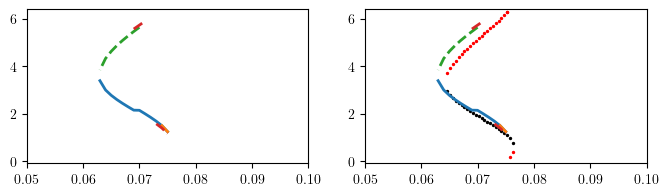

In [214]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(.05,.1,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [215]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06309999999999999 3.384853368595165
phi init 3.384853368595165
Y [-0.10301364  0.23251937  0.09455209  0.40497497  0.21128854  1.98193843  0.26952157  6.28526169]
mkdir ./data/vdp_thal11_b0=-0.6/
* Loading LC data...
self.T 6.283185307179586 omfix 1.000330478345683
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004829885472503968
es_min,phi0 0.06359999999999999 3.384853368595165
phi init 3.384853368595165
Y [-1.08292777e-01  2.25499046e-01  9.53329639e-02  4.05446202e-01 -1.41322943e-01 -1.98717740e+00  4.75726070e-04  6.28797173e+00]
mkdir ./data/vdp_thal11_b1=-0.6/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0007617884627207
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008772052440059136
es_min,phi0 0.06409999999999999 3.384853368595165
phi init 3.384853368595165
Y [-0.1011634   0.23232533  0.09637683  0.40656517 -0.13917207  1.9749241   0.1877

#### Monodromys max

In [216]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07490000000000001 1.1600033884560865
phi init 1.1600033884560865
period_est 6.3000063000063005 time_est 9995.059995059995
iter, eps phase_diffs 0 0.07490000000000001 [1.18795528]                

data1 shape [[0.0749     3.14709282 1.18795528]]
Y [-0.10987906  0.22891324  0.10263509  0.40387387  1.44361382 -1.06844718  0.47952539  6.29454707]
mkdir ./data/vdp_thal11_b0=-0.6/
* Loading LC data...
self.T 6.283185307179586 omfix 1.000330478345683
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004829885472503968
es_min,phi0 0.07440000000000001 1.1600033884560865
phi init 1.1600033884560865
period_est 6.290006290006291 time_est 9993.689993689995
iter, eps phase_diffs 0 0.07440000000000001 [1.30932959]                

data1 shape [[0.0744     3.14809285 1.30932959]]
Y [-0.0975063   0.23213904  0.10341772  0.40982862 -1.41142758  1.09736192  0.03133125  6.29567952]
mkdir ./data/vdp_thal11_b1=-0.6/
* Loading LC data...
se

In [217]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [218]:
twopar_neg = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_21_o2_neg_fixed.dat')
twopar_neg2 = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_21_o2_neg2_fixed.dat')
twopar_pos = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_21_o2_pos_fixed.dat')

(-0.6, 0.006)

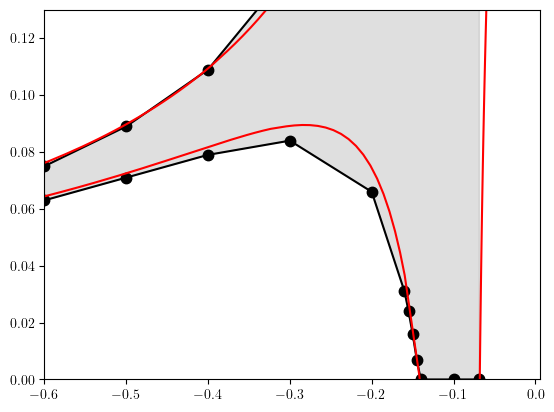

In [219]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.plot(twopar_neg[:,1],twopar_neg[:,0],color='r')
axs.plot(twopar_neg2[:,1],twopar_neg2[:,0],color='r')
axs.plot(twopar_pos[:,1],twopar_pos[:,0],color='r')

axs.set_ylim(0,.13)
axs.set_xlim(-.6,.006)

In [220]:
fname_lo = '../v2_bifdat_2par/full/vdp_thal_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/vdp_thal_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

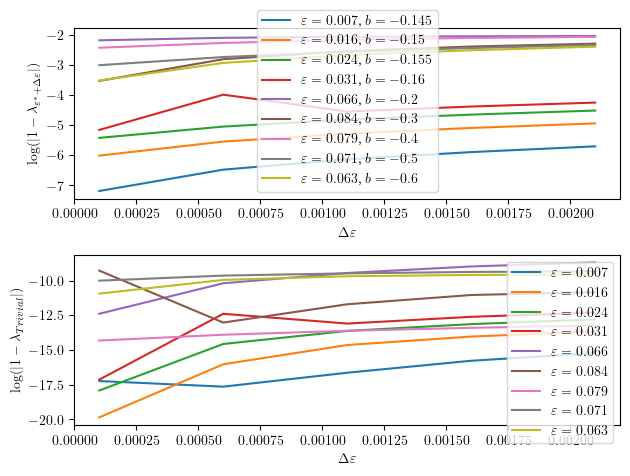

In [221]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(0.0001,0.0001+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

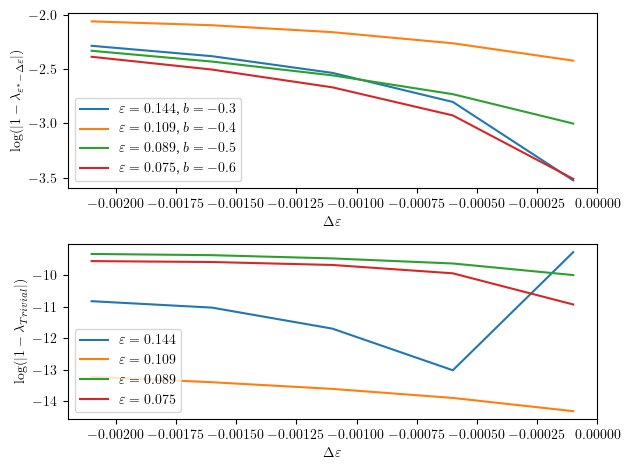

In [222]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_max_{}{}.png'.format(a._n[1],a._m[1]))